# Summary Statistics Based on Moments test
Comparison  between statistics of HH and application of same operations on DAP cell model.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as spstats

In [40]:
from dap import DAPcython
from dap.utils import obs_params, obs_params_gbar, syn_current

In [41]:
# define sumstats parameters
n_mom = 5
n_xcorr = 4

## DAP model

In [42]:
dt = 0.01
params, labels = obs_params_gbar(reduced_model=True)
I, time, t_on, t_off = syn_current(duration=120, dt=0.01)

In [43]:
time

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
       1.2000e+02])

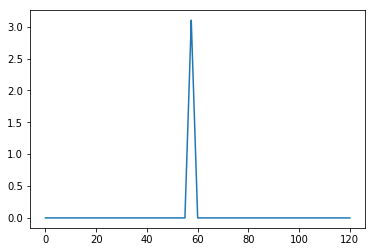

In [44]:
plt.plot(time, I);

In [45]:
params  = params *10

In [46]:
# define models / check setters
dap = DAPcython(-75, params)

In [47]:
# run models
data = dap.simulate(0.01, time, I)

In [48]:
dap_res =  {'data': data.reshape(-1),
        'time': time,
        'dt': dt,
        'I': I}

In [49]:
dap_res['data']

array([-75.        , -75.01674197, -74.99653191, ..., -77.63513083,
       -77.63131475, -77.62531614])

In [50]:
x = dap_res
t = dap_res['time']

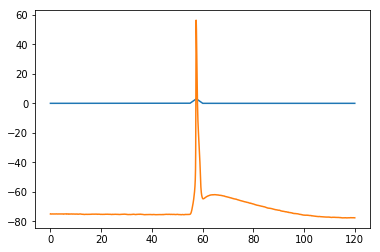

In [51]:
plt.plot(time, I)
plt.plot(time, data);

### Summary Statistics Moments

In [52]:
N = x['data'].shape[0]
t = x['time']
dt = x['dt']

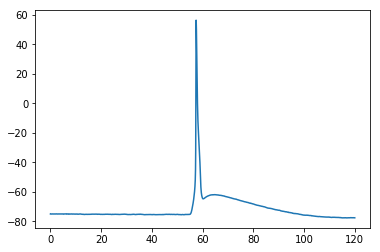

In [53]:
# initialise array of spike counts
v = np.array(x['data'])
plt.plot(t, v);

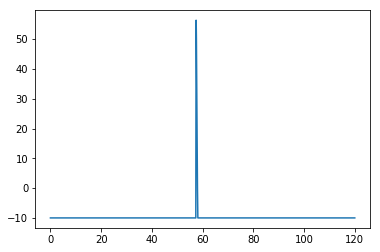

In [54]:
# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
v[ind] = -10
plt.plot(t, v);

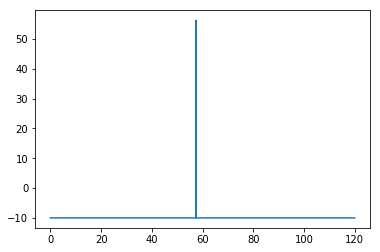

In [55]:
ind = np.where(np.diff(v) < 0)
v[ind] = -10
plt.plot(t, v);

In [56]:
# remaining negative slopes are at spike peaks
ind = np.where(np.diff(v) < 0)
spike_times = np.array(t)[ind]
spike_times

array([57.44])

In [57]:
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]
spike_times_stim

array([57.44])

In [59]:
spike_max = x['data'][ind]
spike_max

array([56.30735412])

In [20]:
# number of spikes
if spike_times_stim.shape[0] > 0:
    spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

spike_times_stim

array([58.02])

### Resting potential

In [60]:
# resting potential and std
rest_pot = np.mean(x['data'][t<t_on])
rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

# TODO: Find relevant lenght of the signal to analyse, not t_on, t_off

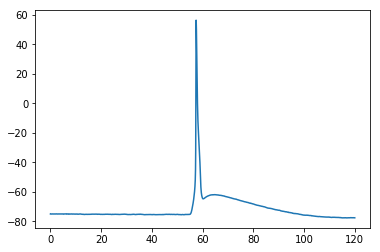

In [61]:
# initialise array of spike counts
v_all = np.array(x['data'])
plt.plot(t, v_all);

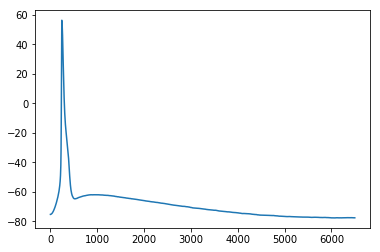

In [62]:
v_all = v_all[(t>t_on)]
plt.plot(v_all);

In [63]:
ind = np.where(v_all > rest_pot)

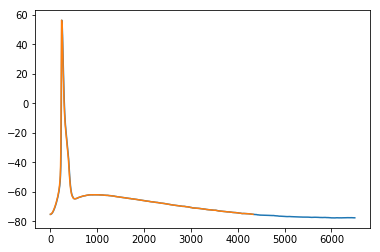

In [67]:
v2 = v_all[ind[0][0]:ind[0][-1]]
plt.plot(v_all);
plt.plot(v2);


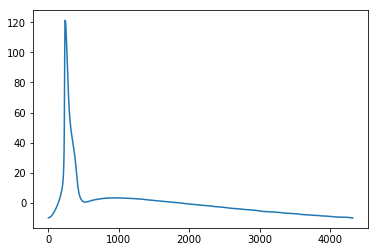

In [68]:
v_on_off = v2 - np.mean(v2)
plt.plot(v_on_off);

### Auto-correlation of the signal

In [27]:
# auto-correlations
# x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_on_off = v_on_off
x_corr_val = np.dot(x_on_off,x_on_off)


In [28]:
xcorr_steps = np.linspace(1./dt,n_xcorr*1./dt,n_xcorr).astype(int)
xcorr_steps

array([100, 200, 300, 400])

In [29]:
x_corr_full = np.zeros(n_xcorr)
x_corr_full

array([0., 0., 0., 0.])

In [30]:
for ii in range(n_xcorr):
    x_on_off_part = np.concatenate((x_on_off[xcorr_steps[ii]:],np.zeros(xcorr_steps[ii])))
    x_corr_full[ii] = np.dot(x_on_off,x_on_off_part)

x_corr1 = x_corr_full/x_corr_val
x_corr1

array([ 0.42797991,  0.07983786, -0.04165178, -0.07176092])

### Moments of the signal

In [31]:
v = v_on_off
v

array([-0.11949222, -0.13626163, -0.11621164, ..., -0.24996835,
       -0.2480077 , -0.24668957])

In [32]:
std_pw = np.power(np.std(v), np.linspace(3,n_mom,n_mom-2))
std_pw

array([  2881.20861477,  40998.34001146, 583388.4693653 ])

In [33]:
std_pw = np.concatenate((np.ones(1),std_pw))
std_pw

array([1.00000000e+00, 2.88120861e+03, 4.09983400e+04, 5.83388469e+05])

In [34]:
moments = spstats.moment(v, np.linspace(2,n_mom,n_mom-1))/std_pw

In [35]:
np.linspace(2,n_mom,n_mom-1)

array([2., 3., 4., 5.])

In [36]:
moments

array([202.48046822,   6.71851053,  55.68908195, 482.41102686])

In [37]:
spstats.moment(v2, moment=[0,1,2,3,4])

array([1.00000000e+00, 0.00000000e+00, 2.02480468e+02, 1.93574304e+04,
       2.28315992e+06])

In [38]:
spstats.moment?


Signature: spstats.moment(a, moment=1, axis=0, nan_policy='propagate')
Docstring:
Calculate the nth moment about the mean for a sample.

A moment is a specific quantitative measure of the shape of a set of
points. It is often used to calculate coefficients of skewness and kurtosis
due to its close relationship with them.


Parameters
----------
a : array_like
   data
moment : int or array_like of ints, optional
   order of central moment that is returned. Default is 1.
axis : int or None, optional
   Axis along which the central moment is computed. Default is 0.
   If None, compute over the whole array `a`.
nan_policy : {'propagate', 'raise', 'omit'}, optional
    Defines how to handle when input contains nan. 'propagate' returns nan,
    'raise' throws an error, 'omit' performs the calculations ignoring nan
    values. Default is 'propagate'.

Returns
-------
n-th central moment : ndarray or float
   The appropriate moment along the given axis or over all values if axis
   is None. Th